# NYT Sentiment Analysis with Tensorflow

In this project, I download monthly abstracts from the NYT for each month during the first year of the Bush, Obama, Trump, and Biden administrations. I then build an NLP sentiment analysis model with tensorflow to see what percentage of newsflow can be categorized as positive or negative for each month.

### Pull data from NYT Archive using pynytimes API

In [19]:
# import necessary packages (I installed via command line with: python -m pip install --upgrade pynytimes)
# pynytimes documentation: https://github.com/michadenheijer/pynytimes#archive-metadata
from pynytimes import NYTAPI
import datetime
import pandas as pd
import json

In [20]:
# initiate connection w/ personal API key
secretAPIkey = 'your-secret-key'
nyt = NYTAPI(secretAPIkey, parse_dates=True)

In [21]:
# example of results
nyt.archive_metadata(date = datetime.datetime(2021, 1, 1))[0]

{'abstract': 'Reasons to be hopeful about the Biden economy.',
 'web_url': 'https://www.nytimes.com/2020/12/31/opinion/2021-economy-recovery.html',
 'snippet': 'Reasons to be hopeful about the Biden economy.',
 'lead_paragraph': 'The next few months will be hell in terms of politics, epidemiology and economics. But at some point in 2021 things will start getting better. And there’s good reason to believe that once the good news starts, the improvement in our condition will be much faster and continue much longer than many people expect.',
 'print_section': 'A',
 'print_page': '18',
 'source': 'The New York Times',
 'multimedia': [{'rank': 0,
   'subtype': 'xlarge',
   'caption': None,
   'credit': None,
   'type': 'image',
   'url': 'images/2020/12/31/opinion/31krugman1/31krugman1-articleLarge.jpg',
   'height': 393,
   'width': 600,
   'subType': 'xlarge',
   'crop_name': 'articleLarge',
   'legacy': {'xlarge': 'images/2020/12/31/opinion/31krugman1/31krugman1-articleLarge.jpg',
    'x

In [22]:
# create dictionary to store results
presidents = {
    'Bush': {'first_year':2001},
    'Obama': {'first_year':2009},
    'Trump': {'first_year':2017},
    'Biden': {'first_year':2021}
    }

# relevant sections of NYT
sections =['Business', 'National', 'Politics', 'World']

# pull data, store in appropriate dictionary
for president in presidents:
    
    # create empty dictionary to contain all abstracts and  abstracts with direct mentions of president's last name
    presidents[president]['abstracts'] = {}
    presidents[president]['direct_mentions'] = {}
    
    for m in range(1,13):
        # add month as key to abstracts/direct mentions dicts, set value to empty list
        presidents[president]['abstracts'][str(m)] = []
        presidents[president]['direct_mentions'][str(m)] = [] 
        
        # create datetime object from month and query NYT archives
        month = datetime.datetime(presidents[president]['first_year'], m, 1)
        data = nyt.archive_metadata(date = month)
        # check if article published in relevant section, and if president's name is directly mentioned
        for article in data:
            if article['section_name'] in sections:
                abstract = article['abstract']
                presidents[president]['abstracts'][str(m)].append(abstract)
                if president in abstract:
                    presidents[president]['direct_mentions'][str(m)].append(abstract)

# save results to a json file so we do not need to pull data again
with open(r'C:\Users\abode\Documents\Data Science\NYT\data.json', 'w') as f:
    json.dump(presidents, f)
    
print('done')

done


In [23]:
nyt.close()

In [24]:
## IF RELOADING DATA (don't want to pull from API again)

# with open(r'C:\Users\abode\Documents\Data Science\NYT\data.json') as json_file:
#    presidents = json.load(json_file)

## Simple NLP with TextBlob

We will now use a very simple library [(TextBlob)](https://textblob.readthedocs.io/en/dev/) to perform sentiment analysis on our abstracts. We will then take a look at whether it appears to be successful or not, by looking at a sample of abstracts and their predicted sentiment.

In [25]:
from textblob import TextBlob

In [26]:
def get_abstract_sentiment(abstract):
    analysis = TextBlob(abstract)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

for abstract in presidents['Obama']['abstracts']['1'][10:16]:
    print(abstract)
    print(get_abstract_sentiment(abstract), '\n')

A fire at a high-end Bangkok nightclub killed at least 59 people and injured more than 200 shortly after midnight as revelers were celebrating the new year, the police said.
positive 

Massing tanks and troops along the Gaza border, Israel pursued diplomatic avenues to explain its positions, and a strike killed a Hamas leader.
negative 

The Russian energy giant Gazprom shut natural gas deliveries in a move that could spell shortages for Europe.
positive 

Taliban militants attacked police assigned to protect an official, killing 20 of them in one of the bloodiest attacks on the security forces in months, local officials reported.
neutral 

Mrs. Suzman befriended the imprisoned Nelson Mandela and offered an often lonely voice for change among South Africa’s white minority.
negative 

Control of the Green Zone reverted to Iraqi control as part of the recent security agreement with the U.S.
negative 



Clearly this classification model is not working very well. The fact that a fire killed 59 people and injuring more than 200 is classified as "positive" is pretty crazy. Seeing this, it made me wonder if I could create a more accurate classifier and practice using tensorflow at the same time.

## Training/using an NLP model with tensorflow

I will now build my own NLP model, using a [labeled dataset](https://www.kaggle.com/kazanova/sentiment140) of 1.6MM tweets downloaded from Kaggle.

First we'll install/import the necessary tensorflow modules. note, I had to run a few commands to get tensorflow_hub to work for me. These included:
* python -m pip install --upgrade tensorflow_hub
* pip uninstall tf-estimator-nightly tensorflow-estimator && pip install tf-estimator-nightly==2.4.0.dev2020101001
* pip install --upgrade tensorflow-estimator==2.3.0

The tutorial I used to help me through this project can be found [here](https://www.tensorflow.org/hub/tutorials/tf2_text_classification)

In [27]:
import tensorflow as tf
import tensorflow_hub as hub

In [28]:
# column titles
header_list = ['target', 'ids', 'date', 'flag', 'user', 'text']

# open csv you download from Kaggle in Notepad, then "save as" with UTF-8 encoding
labeled_tweets = pd.read_csv('training.1600000.processed.noemoticon.csv', names=header_list)
labeled_tweets = labeled_tweets[['target','text']] # include only the columns we care about
labeled_tweets['target'].replace(4,1,inplace=True) # not strictly necessary, just recoded "positive" to be 1 instead of 4
labeled_tweets.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [29]:
# The dataset description says there is a neutral label but there are no neutral labels in the dataset
print('Negative Tweets:',len(labeled_tweets[labeled_tweets['target']==0]))
print('Positive Tweets:',len(labeled_tweets[labeled_tweets['target']==1]))

Negative Tweets: 800000
Positive Tweets: 800000


In [30]:
# create random train dataframe, with 80% of the data, test set with the remaining 20%
train = labeled_tweets.sample(frac=0.8) 
test = labeled_tweets.drop(train.index)

# turn columns into numpy arrays to use as inputs for training
train_examples, train_labels = train['text'].values, train['target'].values
test_examples, test_labels = test['text'].values, test['target'].values

In [31]:
# I needed to set up a directory for my tensorflow hub downloads to go to
import os
os.environ['TFHUB_CACHE_DIR'] = r'C:\Users\abode\Documents\Data Science\Tensor Flow\tf modules'

# we need to "tokenize" our inputs, convert our abstracts into numerical values
# I will use the tokenization model below, on tensorflow hub
model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

# example of tokenization of an abstract
hub_layer(train_examples[0:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.02658028, -0.09772534, -0.01575587,  0.07774093,  0.12727807,
        -0.13316076, -0.01769425, -0.12485762, -0.07248454,  0.01822883,
        -0.14585893,  0.00447521, -0.15491574, -0.07313804,  0.19325636,
         0.06565783,  0.02222507,  0.02928767, -0.12259157, -0.17316523,
         0.1133112 ,  0.01786883, -0.04696574, -0.00336145, -0.1204062 ,
         0.16387257, -0.05053407, -0.03893531, -0.04547245,  0.04783821,
        -0.07781563,  0.12298203,  0.09345517,  0.03844193,  0.11121865,
         0.13432561, -0.17333227, -0.02238974, -0.03906756, -0.00456211,
        -0.03392179, -0.08573876,  0.0612272 , -0.1084713 ,  0.1709402 ,
         0.1609702 ,  0.09487601,  0.05127693, -0.05268176,  0.11603395,
         0.08768135, -0.012691  ,  0.08769303, -0.16138603, -0.0641731 ,
         0.09385896, -0.20515575,  0.15277667, -0.00041164, -0.13673322,
         0.05308207,  0.06408086,  0.03883106,  0.12774932,  0.06277701,
 

In [32]:
# create a Sequential neural network
model = tf.keras.Sequential()
model.add(hub_layer) # add tokenization layer
model.add(tf.keras.layers.Dense(16, activation='relu')) # create hidden layer with 16 nodes
model.add(tf.keras.layers.Dense(8, activation='relu')) # create hidden layer with 8 nodes
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output layer, 1 node, sigmoid, for binary classification
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 124,644,897
Trainable params: 124,644,897
Non-trainable params: 0
______

In [33]:
# compile model, designed for binary classification
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [34]:
# set aside some of the example datapoints for validation during training
x_val = train_examples[:100000]
partial_x_train = train_examples[100000:]

y_val = train_labels[:100000]
partial_y_train = train_labels[100000:]

print(len(x_val), len(partial_x_train))

100000 1180000


In [35]:
# train the model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=50000,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7111 - accuracy: 0.5136WARNING:tensorflow:8 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x000002AA07C96790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


24/24 [==============================] - 44s 2s/step - loss: 0.7111 - accuracy: 0.5136 - val_loss: 0.6953 - val_accuracy: 0.5157
Epoch 2/10
24/24 [==============================] - 35s 1s/step - loss: 0.6805 - accuracy: 0.5431 - val_loss: 0.6644 - val_accuracy: 0.6055
Epoch 3/10
24/24 [==============================] - 37s 2s/step - loss: 0.6498 - accuracy: 0.6705 - val_loss: 0.6343 - val_accuracy: 0.7280
Epoch 4/10
24/24 [==============================] - 36s 1s/step - loss: 0.6226 - accuracy: 0.7476 - val_loss: 0.6134 - val_accuracy: 0.7635
Epoch 5/10
24/24 [==============================] - 35s 1s/step - loss: 0.6068 - accuracy: 0.7746 - val_loss: 0.6044 - val_accuracy: 0.7781
Epoch 6/10
24/24 [==============================] - 41s 2s/step - loss: 0.5996 - accuracy: 0.7874 - val_loss: 0.6007 - val_accuracy: 0.7837
Epoch 7/10
24/24 [==============================] - 41s 2s/step - loss: 0.5954 - accuracy: 0.7955 - val_loss: 0.5988 - val_accuracy: 0.7870
Epoch 8/10
24/24 [=============

In [36]:
# evaluate performance on test set
results = model.evaluate(test_examples, test_labels)
print(results)

10000/10000 [==============================] - 2843s 284ms/step - loss: 0.5966 - accuracy: 0.7886
[0.5966139435768127, 0.7886250019073486]


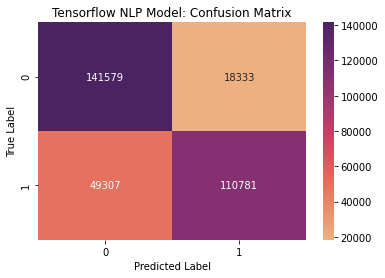

In [37]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (model.predict(test_examples) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(test_labels, predictions)

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

# we can see that our model has a negative bias

In [59]:
## save our model for future use, so we don't have to retrain each time
# model.save(r'saved_model\twitter_npl2.h5')

## if we want to reload it, without retraining it:
## NOT WORKING...IDK WHY:
# new_model = tf.keras.models.load_model(r'saved_model\twitter_npl.h5', custom_objects={'KerasLayer': hub.KerasLayer})

## Compare performance on tweet dataset: Tensorflow vs. TextBlob

Note: TextBlob predicts "neutral" sentiment as well. Therefore, this won't be a direct comparison, but it will be helpful nonetheless. We will randomly choose to reclassify TextBlob's "neutral" predictions as either "positive" or "negative." From above, we can see that our tensorflow accuracy was **79%**.

In [66]:
import random

# change function to recategorize neutrals
def get_abstract_sentiment_2(abstract):
    analysis = TextBlob(abstract)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0 and random.random() > 0.5:
        return 1
    else:
        return 0

# loop through test examples and check if TextBlob's prediction matches actual label
correct = 0
incorrect = 0
for i in range(len(test_examples)):
    if test_labels[i] == get_abstract_sentiment_2(test_examples[i]):
        correct += 1
    else:
        incorrect += 1

print('Accuracy:', correct/(correct+incorrect))

Accuracy: 0.6165375


## Compare performance on random sample of abstracts: Tensorflow vs. TextBlob

We will let TextBlob predict "Neutral" again. With Tensorflow we are able to classify a headline about fire, death, and injury as "negative" instead of "positive".

In [40]:
for abstract in presidents['Obama']['abstracts']['1'][10:20]:
    print(abstract)
    
    text_blob = get_abstract_sentiment(abstract)
    
    tensor_flow = (model.predict([abstract]) > 0.5).astype("int32")[0][0]
    if tensor_flow == 1:
        tensor_flow = 'positive'
    else:
        tensor_flow = 'negative'
        
    print('TextBlob prediction:', text_blob, '|', 'Tensorflow prediction:', tensor_flow, '\n')

A fire at a high-end Bangkok nightclub killed at least 59 people and injured more than 200 shortly after midnight as revelers were celebrating the new year, the police said.
TextBlob prediction: positive | Tensorflow prediction: negative 

Massing tanks and troops along the Gaza border, Israel pursued diplomatic avenues to explain its positions, and a strike killed a Hamas leader.
TextBlob prediction: negative | Tensorflow prediction: negative 

The Russian energy giant Gazprom shut natural gas deliveries in a move that could spell shortages for Europe.
TextBlob prediction: positive | Tensorflow prediction: negative 

Taliban militants attacked police assigned to protect an official, killing 20 of them in one of the bloodiest attacks on the security forces in months, local officials reported.
TextBlob prediction: neutral | Tensorflow prediction: negative 

Mrs. Suzman befriended the imprisoned Nelson Mandela and offered an often lonely voice for change among South Africa’s white minori

## Use tf NLP model to get sentiment for all abstracts in each month

In [43]:
# loop through presidents, for each month predict the sentiment for all abstracts and direct mentions
for president in presidents:
    presidents[president]['sentiment (predictions)'] ={'all':{}, 'direct':{}}
    presidents[president]['sentiment (%)'] = {}
    
    for month in range(1,13):
        all_abstracts = presidents[president]['abstracts'][str(month)]   
        all_sentiment = (model.predict(all_abstracts) > 0.5).astype('int')
        all_sentiment = [int(prediction[0]) for prediction in all_sentiment]
        
        direct_abstracts = presidents[president]['direct_mentions'][str(month)]
        direct_sentiment = (model.predict(direct_abstracts) > 0.5).astype('int')
        direct_sentiment = [int(prediction[0]) for prediction in direct_sentiment]
        
        presidents[president]['sentiment (predictions)']['all'][str(month)] = all_sentiment
        presidents[president]['sentiment (predictions)']['direct'][str(month)] = direct_sentiment
        
        presidents[president]['sentiment (%)'][str(month)] = {}
        presidents[president]['sentiment (%)'][str(month)]['positive (all)'] = sum(all_sentiment)/len(all_sentiment)
        presidents[president]['sentiment (%)'][str(month)]['negative (all)'] = 1 - (sum(all_sentiment)/len(all_sentiment))
        presidents[president]['sentiment (%)'][str(month)]['positive (direct)'] = sum(direct_sentiment)/len(direct_sentiment)
        presidents[president]['sentiment (%)'][str(month)]['negative (direct)'] = 1 - (sum(direct_sentiment)/len(direct_sentiment))

# save results to a json file for future projects
with open(r'C:\Users\abode\Documents\Data Science\NYT\president_df_final.json', 'w') as f:
    json.dump(presidents, f)

## Visualize Results

In [44]:
# rearrange results into a simple pandas dataframe
# President | Month | Positive (All) | Negative (All) | Positive (DIRECT) | Negative (DIRECT)
# Obama | January | 58% | 42% | 55% | 45%

final_df = pd.DataFrame(columns=['president', 'month', 'positive (all)', 'negative (all)', 'positive (direct)', 'negative (direct)'])

for president in presidents:
    for month in range(1,13):
        final_df = final_df.append({'president': president,
                                    'month': month,
                                    'positive (all)': presidents[president]['sentiment (%)'][str(month)]['positive (all)'],
                                    'negative (all)': presidents[president]['sentiment (%)'][str(month)]['negative (all)'],
                                    'positive (direct)': presidents[president]['sentiment (%)'][str(month)]['positive (direct)'],
                                    'negative (direct)': presidents[president]['sentiment (%)'][str(month)]['negative (direct)'],
                                   },
                                   ignore_index=True)

final_df

,president,month,positive (all),negative (all),positive (direct),negative (direct)
0,Bush,1,0.259101,0.740899,0.423077,0.576923
1,Bush,2,0.270270,0.729730,0.222222,0.777778
2,Bush,3,0.268775,0.731225,0.424658,0.575342
3,Bush,4,0.244856,0.755144,0.250000,0.750000
4,Bush,5,0.260116,0.739884,0.356322,0.643678
5,Bush,6,0.309598,0.690402,0.422535,0.577465
6,Bush,7,0.245098,0.754902,0.271429,0.728571
7,Bush,8,0.294304,0.705696,0.200000,0.800000
8,Bush,9,0.234177,0.765823,0.206186,0.793814
9,Bush,10,0.217520,0.782480,0.180952,0.819048


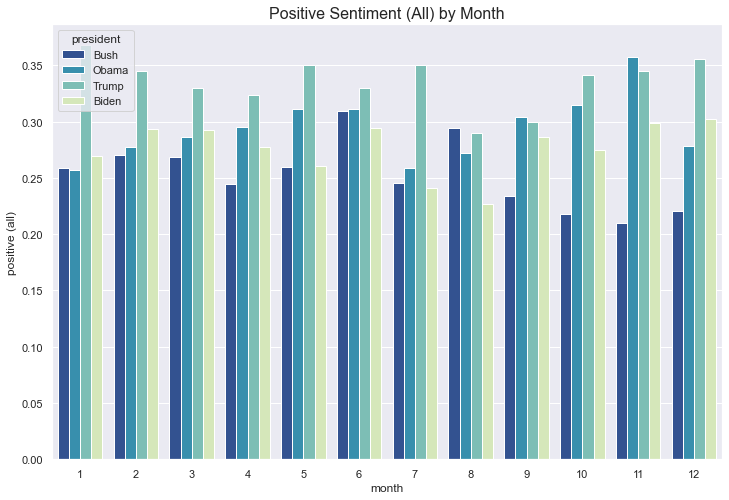

In [45]:
sns.set(rc={'figure.figsize':(12,8)})

ax = plt.axes()
sns.barplot(x=final_df['month'], y=final_df['positive (all)'], hue=final_df['president'], palette='YlGnBu_r')
ax.set_title('Positive Sentiment (All) by Month', fontsize=16)
plt.show()

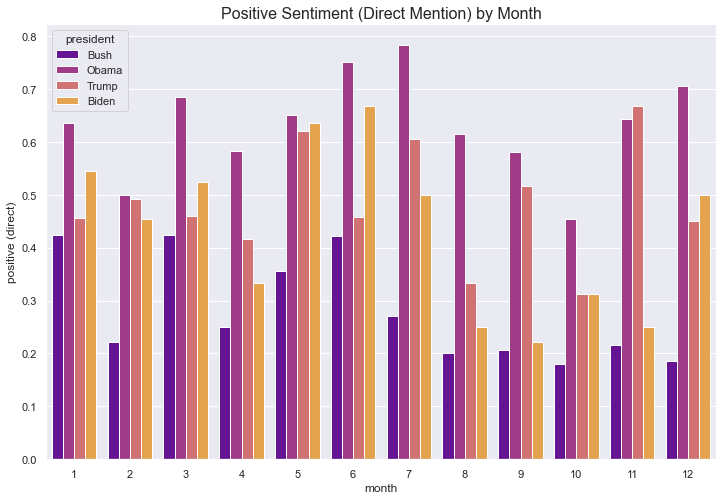

In [46]:
ax = plt.axes()
sns.barplot(x=final_df['month'], y=final_df['positive (direct)'], hue=final_df['president'], palette='plasma')
ax.set_title('Positive Sentiment (Direct Mention) by Month', fontsize=16)
plt.show()

In [47]:
summary_df = final_df.groupby(by=['president']).mean()
summary_df

,positive (all),negative (all),positive (direct),negative (direct)
president,,,,
Biden,0.276599,0.723401,0.432908,0.567092
Bush,0.252861,0.747139,0.279873,0.720127
Obama,0.293768,0.706232,0.632041,0.367959
Trump,0.335788,0.664212,0.482299,0.517701


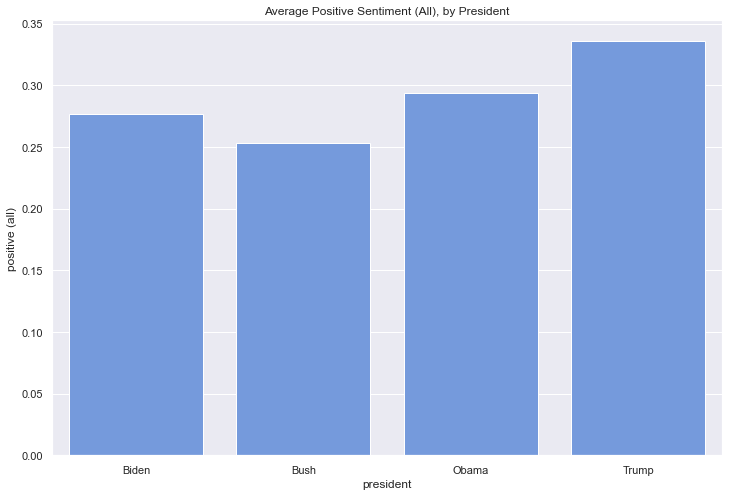

In [48]:
ax = plt.axes()
sns.barplot(x=summary_df.index, y=summary_df['positive (all)'], color='cornflowerblue')
ax.set_title('Average Positive Sentiment (All), by President')
plt.show()

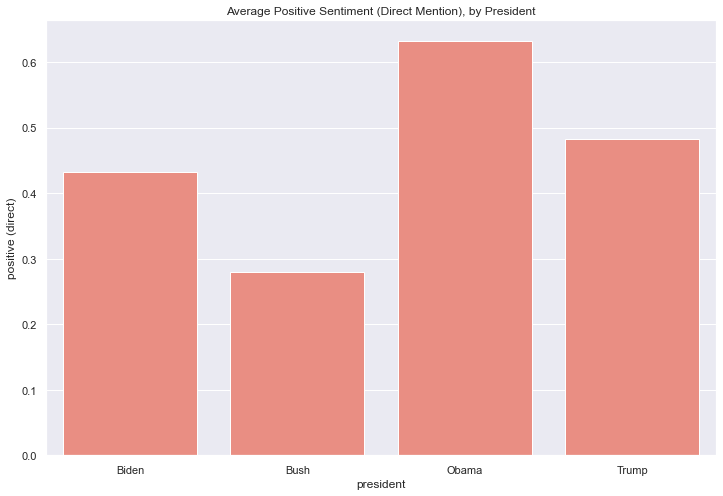

In [49]:
ax = plt.axes()
sns.barplot(x=summary_df.index, y=summary_df['positive (direct)'], color='salmon')
ax.set_title('Average Positive Sentiment (Direct Mention), by President')
plt.show()

## Investigating some interesting findings

Trump sentiment is surprisingly positive. Let's look at a sampling of headlines from May, when his direct mention positive sentiment was 60%

Next, let's check out Obama's 87% positive direct mentions in July.

In [50]:
for i in range(10):
    print(presidents['Trump']['direct_mentions']['5'][i])
    print(presidents['Trump']['sentiment (predictions)']['direct']['5'][i], '\n')

The Philippines leader, who is accused of ordering extrajudicial killings, has said he “cannot make any definite promise” to accept President Trump’s invitation.
0 

President Trump‘s willingness to meet with the North Korean and Philippine leaders illustrated his confidence in his own deal making but alarmed critics.
1 

In their first conversation since last month’s rupture over Syria, President Trump said he would send a representative to Russian-sponsored talks.
1 

South Koreans head to the polls on May 9. The leader they choose will face many uncertainties, not least of them President Trump.
0 

Beneath the bonhomie, experts say, are differences of strategic interest that may keep President Trump from getting the results he wants on North Korea.
1 

Meeting with the Palestinian leader, Mahmoud Abbas, President Trump said, “We will get this done,” a bold promise given the complexity of any peace deal.
1 

The Kremlin cannot understand why President Trump has met a string of world 

Perhaps the positive news abstracts are influenced by Trump's own language choices (bold, positive terms). Or perhaps the world wasn't facing as many calamities in Trump's first year vs. Bush's (terrorism), Biden's (COVID), and Obama's (financial crisis) and therefore the general tone of the news was more positive? Further analysis should be done!

In [51]:
for i in range(10):
    print(presidents['Obama']['direct_mentions']['7'][i])
    print(presidents['Obama']['sentiment (predictions)']['direct']['7'][i], '\n')

The Israeli defense minister and the Obama administration’s Middle East envoy will confer for the second time in a week to pursue regional peace efforts, a senior Israeli official said.
1 

As he heads to Moscow, President Obama faces a complex political dynamic: a country with two leaders, President Dmitri A. Medvedev and Prime Minister Vladimir V. Putin.
1 

President Obama is pushing for new global rules, treaties and alliances to establish a nuclear-free world, a vision he developed as a college student.
1 

President Obama raised concerns about the treatment of a businessman, Mikhail B. Khodorkovsky, who along with his partner has been put back on trial six years after they were first arrested.
1 

President Obama and President Dmitri A. Medvedev announced a preliminary agreement on cutting their stockpiles of nuclear weapons.
1 

The following is a text of President Obama’s remarks delivered at the New Economic School in Moscow, as released by the White House.
1 

President Obama

In this sample for Obama, we can see our classifier is definitely making some mistakes. The lack of fanfare in Moscow should probably be categorized as negative, unless our classifier is just super smart and knows that we don't want to be too popular with Putin!

In [68]:
import jovian
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Committed successfully! https://jovian.ai/abode118/nyt-sentiment-analysis


'https://jovian.ai/abode118/nyt-sentiment-analysis'